In [ ]:
import pandas as pd

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler

from sklearn.metrics import classification_report

import torch
from torch.utils.data import Dataset, DataLoader
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F

import matplotlib.pyplot as plt

In [13]:
# 1. Загрузка данных
df = pd.read_csv('./content/cybersequrity.csv')

# Просмотр первых 5 строк
print(df.head())

   svcscan.fs_drivers  callbacks.ngeneric  \
0                  26                   8   
1                  26                   8   
2                  26                   8   
3                  26                   8   
4                  26                   8   

   psxview.not_in_eprocess_pool_false_avg  psxview.not_in_eprocess_pool  \
0                                     0.0                             0   
1                                     0.0                             0   
2                                     0.0                             0   
3                                     0.0                             0   
4                                     0.0                             0   

   callbacks.nanonymous  psxview.not_in_session  psxview.not_in_pslist  \
0                     0                       2                      0   
1                     0                       5                      3   
2                     0                       9         

In [14]:
# 2. Определение признаков и целевой переменной
X = df.drop(columns='Class').values  # Все столбцы, кроме 'Class'
y = df['Class'].values  # Целевая переменная

# Разделение на обучающую, валидационную и тестовую выборки (60/20/20) со стратификацией
X_train, X_temp, y_train, y_temp = train_test_split(X, y, test_size=0.4, stratify=y, random_state=42)
X_val, X_test, y_val, y_test = train_test_split(X_temp, y_temp, test_size=0.5, stratify=y_temp, random_state=42)

In [15]:
# 3. Стандартизация данных
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_val = scaler.transform(X_val)
X_test = scaler.transform(X_test)

In [16]:
# 4. Преобразование данных в тензоры
X_train_tensor = torch.FloatTensor(X_train)
X_val_tensor = torch.FloatTensor(X_val)
X_test_tensor = torch.FloatTensor(X_test)
y_train_tensor = torch.FloatTensor(y_train)
y_val_tensor = torch.FloatTensor(y_val)
y_test_tensor = torch.FloatTensor(y_test)

In [17]:
# 5. Создание класса Dataset
class CybersecurityDataset(Dataset):
    def __init__(self, features, labels):
        self.features = features
        self.labels = labels
        
    def __len__(self):
        return len(self.labels)
    
    def __getitem__(self, idx):
        return self.features[idx], self.labels[idx]

In [18]:
# 6. Выбор batch_size
batch_size = 32  # Можно попробовать другие значения, если качество модели не устраивает

In [19]:
# 7. Создание DataLoader
train_dataset = CybersecurityDataset(X_train_tensor, y_train_tensor)
val_dataset = CybersecurityDataset(X_val_tensor, y_val_tensor)
test_dataset = CybersecurityDataset(X_test_tensor, y_test_tensor)

train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

In [20]:
# 8. Проверка размерностей выборок
print(f'Train size: {len(train_loader)}, Validation size: {len(val_loader)}, Test size: {len(test_loader)}')

Train size: 188, Validation size: 63, Test size: 63


### Реализация класса MLP

1. Структура модели: Мы используем несколько линейных слоев для обработки данных.
2. Функции активации: Часто используемыми функциями активации в скрытых слоях являются ReLU и LeakyReLU.
3. Метод forward: Реализуем логику прохождения данных через сеть.

In [21]:
class MLP(nn.Module):
    def __init__(self, input_dim, hidden_dims, output_dim):
        super(MLP, self).__init__()
        
        # Определяем слои
        layers = []
        in_dim = input_dim
        
        # Создаем скрытые слои
        for hidden_dim in hidden_dims:
            layers.append(nn.Linear(in_dim, hidden_dim))
            layers.append(nn.ReLU())  # Используем активацию ReLU
            in_dim = hidden_dim
        
        # Выходной слой
        layers.append(nn.Linear(in_dim, output_dim))
        layers.append(nn.Sigmoid())  # Используем сигмоид для бинарной классификации
        
        self.model = nn.Sequential(*layers)
    
    def forward(self, x):
        return self.model(x)

# Параметры модели
input_dim = X_train.shape[1]  # Количество входных признаков
hidden_dims = [64, 32]  # Размерности скрытых слоев
output_dim = 1  # Для бинарной классификации

# Создание объекта модели
model = MLP(input_dim, hidden_dims, output_dim)

# Проверка наличия GPU и перевод модели на GPU, если доступен
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model.to(device)

# Печать структуры модели
print(model)

MLP(
  (model): Sequential(
    (0): Linear(in_features=15, out_features=64, bias=True)
    (1): ReLU()
    (2): Linear(in_features=64, out_features=32, bias=True)
    (3): ReLU()
    (4): Linear(in_features=32, out_features=1, bias=True)
    (5): Sigmoid()
  )
)


### Обучение и валидации модели

Epoch [1/50], Train Loss: 0.6663, Val Loss: 0.6507
Epoch [2/50], Train Loss: 0.6365, Val Loss: 0.6318
Epoch [3/50], Train Loss: 0.6105, Val Loss: 0.6080
Epoch [4/50], Train Loss: 0.5812, Val Loss: 0.5663
Epoch [5/50], Train Loss: 0.5498, Val Loss: 0.5410
Epoch [6/50], Train Loss: 0.5250, Val Loss: 0.5133
Epoch [7/50], Train Loss: 0.5068, Val Loss: 0.4959
Epoch [8/50], Train Loss: 0.4907, Val Loss: 0.4968
Epoch [9/50], Train Loss: 0.4895, Val Loss: 0.4881
Epoch [10/50], Train Loss: 0.4788, Val Loss: 0.4822
Epoch [11/50], Train Loss: 0.4748, Val Loss: 0.4621
Epoch [12/50], Train Loss: 0.4741, Val Loss: 0.4654
Epoch [13/50], Train Loss: 0.4684, Val Loss: 0.4669
Epoch [14/50], Train Loss: 0.4654, Val Loss: 0.4545
Epoch [15/50], Train Loss: 0.4651, Val Loss: 0.4638
Epoch [16/50], Train Loss: 0.4608, Val Loss: 0.4565
Epoch [17/50], Train Loss: 0.4544, Val Loss: 0.4503
Epoch [18/50], Train Loss: 0.4519, Val Loss: 0.4542
Epoch [19/50], Train Loss: 0.4568, Val Loss: 0.4677
Epoch [20/50], Train 

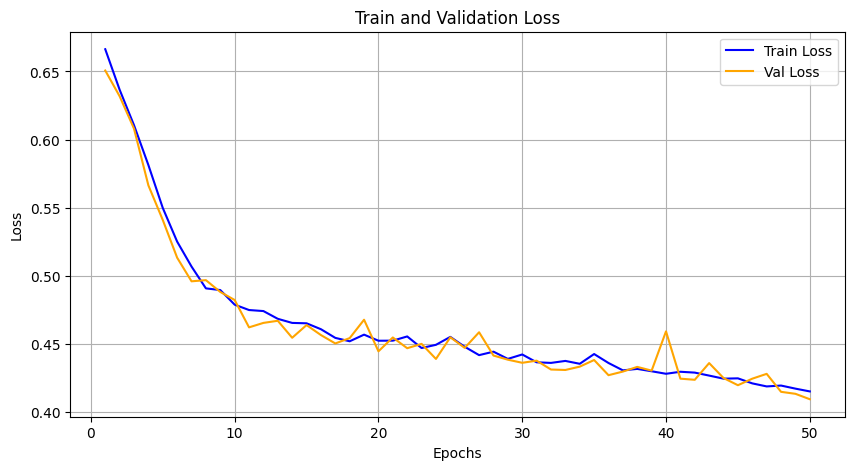

In [22]:
# Определение функции потерь и оптимизатора
criterion = nn.BCELoss()  # Функция потерь для бинарной классификации
optimizer = optim.Adam(model.parameters(), lr=0.001)  # Оптимизатор Adam

# Параметры обучения
num_epochs = 50

train_losses = []
val_losses = []

def train(model, train_loader, criterion, optimizer):
    model.train()  # Устанавливаем режим обучения
    running_loss = 0.0
    for features, labels in train_loader:
        features, labels = features.to(device), labels.to(device)  # Перенос данных на устройство
        optimizer.zero_grad()  # Обнуляем градиенты
        outputs = model(features).squeeze()  # Прямой проход
        loss = criterion(outputs, labels)  # Вычисляем функцию потерь
        loss.backward()  # Обратное распространение ошибки
        optimizer.step()  # Обновляем параметры
        running_loss += loss.item()  # Сохраняем потери

    return running_loss / len(train_loader)  # Возвращаем среднюю потерю

def evaluate(model, val_loader, criterion):
    model.eval()  # Устанавливаем режим валидации
    running_loss = 0.0
    with torch.no_grad():  # Выключаем градиенты
        for features, labels in val_loader:
            features, labels = features.to(device), labels.to(device)
            outputs = model(features).squeeze()
            loss = criterion(outputs, labels)
            running_loss += loss.item()

    return running_loss / len(val_loader)  # Возвращаем среднюю потерю

# Цикл обучения и валидации
for epoch in range(num_epochs):
    train_loss = train(model, train_loader, criterion, optimizer)
    val_loss = evaluate(model, val_loader, criterion)

    train_losses.append(train_loss)
    val_losses.append(val_loss)

    print(f'Epoch [{epoch + 1}/{num_epochs}], Train Loss: {train_loss:.4f}, Val Loss: {val_loss:.4f}')

# Визуализация потерь
plt.figure(figsize=(10, 5))
plt.plot(range(1, num_epochs + 1), train_losses, label='Train Loss', color='blue')
plt.plot(range(1, num_epochs + 1), val_losses, label='Val Loss', color='orange')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Train and Validation Loss')
plt.legend()
plt.grid()
plt.show()

In [23]:
# Тестирование модели
model.eval()
y_pred_list = []
y_true_list = []

with torch.no_grad():
    for features, labels in test_loader:
        features = features.to(device)
        outputs = model(features).squeeze()
        predicted = (outputs > 0.5).float()  # Преобразуем вероятности в класс
        y_pred_list.extend(predicted.cpu().numpy())
        y_true_list.extend(labels.numpy())

In [24]:
# Отчет о классификации

print(classification_report(y_true_list, y_pred_list))

              precision    recall  f1-score   support

         0.0       0.78      0.82      0.80       981
         1.0       0.82      0.78      0.80      1019

    accuracy                           0.80      2000
   macro avg       0.80      0.80      0.80      2000
weighted avg       0.80      0.80      0.80      2000



Epoch [1/50], Train Loss: 0.6508, Val Loss: 0.6344
Epoch [2/50], Train Loss: 0.6049, Val Loss: 0.6126
Epoch [3/50], Train Loss: 0.5720, Val Loss: 0.5840
Epoch [4/50], Train Loss: 0.5691, Val Loss: 0.6217
Epoch [5/50], Train Loss: 0.5583, Val Loss: 0.5900
Epoch [6/50], Train Loss: 0.5598, Val Loss: 0.6359
Epoch [7/50], Train Loss: 0.5503, Val Loss: 0.6637
Epoch [8/50], Train Loss: 0.5406, Val Loss: 0.5616
Epoch [9/50], Train Loss: 0.5348, Val Loss: 0.5978
Epoch [10/50], Train Loss: 0.5472, Val Loss: 0.5910
Epoch [11/50], Train Loss: 0.5361, Val Loss: 0.6185
Epoch [12/50], Train Loss: 0.5375, Val Loss: 0.6438
Epoch [13/50], Train Loss: 0.5270, Val Loss: 0.5904
Epoch [14/50], Train Loss: 0.5335, Val Loss: 0.5269
Epoch [15/50], Train Loss: 0.5275, Val Loss: 0.5209
Epoch [16/50], Train Loss: 0.5293, Val Loss: 0.5431
Epoch [17/50], Train Loss: 0.5201, Val Loss: 0.5078
Epoch [18/50], Train Loss: 0.5254, Val Loss: 0.5929
Epoch [19/50], Train Loss: 0.5241, Val Loss: 0.5263
Epoch [20/50], Train 

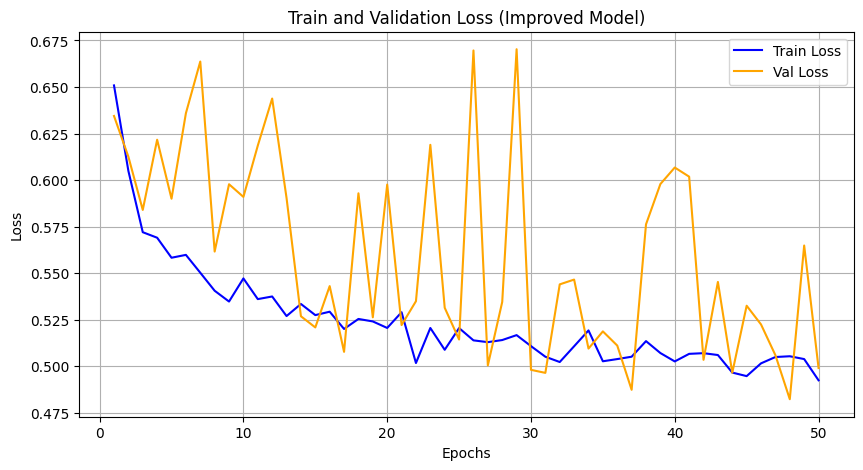

In [25]:
# Реализация улучшенной модели

class ImprovedMLP(nn.Module):
    def __init__(self, input_dim, hidden_dims, output_dim, dropout_rate):
        super(ImprovedMLP, self).__init__()
        layers = []
        in_dim = input_dim

        for hidden_dim in hidden_dims:
            layers.append(nn.Linear(in_dim, hidden_dim))
            layers.append(nn.BatchNorm1d(hidden_dim))  # Добавляем слой нормализации
            layers.append(nn.ReLU())
            layers.append(nn.Dropout(dropout_rate))  # Добавляем слой Dropout
            in_dim = hidden_dim

        layers.append(nn.Linear(in_dim, output_dim))
        layers.append(nn.Sigmoid())
        self.model = nn.Sequential(*layers)

    def forward(self, x):
        return self.model(x)

# Определение гиперпараметров
dropout_rate = 0.3 
hidden_dims = [64, 32]  # Размерности скрытых слоев

# Создание и перенос улучшенной модели на устройство
improved_model = ImprovedMLP(input_dim, hidden_dims, output_dim, dropout_rate)
improved_model.to(device)

# Параметры обучения
num_epochs = 50
optimizer = optim.Adam(improved_model.parameters(), lr=0.001) 

# Обучение улучшенной модели
train_losses = []
val_losses = []

for epoch in range(num_epochs):
    train_loss = train(improved_model, train_loader, criterion, optimizer)
    val_loss = evaluate(improved_model, val_loader, criterion)
    train_losses.append(train_loss)
    val_losses.append(val_loss)
    print(f'Epoch [{epoch + 1}/{num_epochs}], Train Loss: {train_loss:.4f}, Val Loss: {val_loss:.4f}')

# Визуализация потерь
plt.figure(figsize=(10, 5))
plt.plot(range(1, num_epochs + 1), train_losses, label='Train Loss', color='blue')
plt.plot(range(1, num_epochs + 1), val_losses, label='Val Loss', color='orange')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Train and Validation Loss (Improved Model)')
plt.legend()
plt.grid()
plt.show()

In [26]:
# Тестирование улучшенной модели
improved_model.eval()
y_pred_list = []
y_true_list = []

with torch.no_grad():
    for features, labels in test_loader:
        features = features.to(device)
        outputs = improved_model(features).squeeze()
        predicted = (outputs > 0.5).float()  # Преобразуем вероятности в класс
        y_pred_list.extend(predicted.cpu().numpy())
        y_true_list.extend(labels.numpy())

In [27]:
# Отчет о классификации
print("Classification Report for Improved Model:")
print(classification_report(y_true_list, y_pred_list))

Classification Report for Improved Model:
              precision    recall  f1-score   support

         0.0       0.79      0.71      0.75       981
         1.0       0.75      0.82      0.78      1019

    accuracy                           0.77      2000
   macro avg       0.77      0.77      0.77      2000
weighted avg       0.77      0.77      0.77      2000

